# MUADecoding.ipynb

## Multiunit activity (MUA) decoding for replay and other short duration events

Here I will detect putative replay events, based on multiunit activity (MUA). Further, I will detect sharp wave ripples (SWRs) and I will investigate the coincidence or correspondence between MUA events and SWRs. Then, I will decode sequences in MUA events, as well as in SWR events, and visualize the trajectories in real position space. This will give me a qualitative idea of how many spatially-consistent sequences there are in the two sets of data.

Finally, I will implement conventional replay detection, so that we can compare replay events based on our KL score with events identified using conventional methods. These comparisons will likely be moved into their own separate notebook.

========================================================
 From Kourosh
========================================================

The steps are as follows:

1) calculating spike density with convolving a gaussian kernel (sigma = 10 ms and half bandwidth = 3*sigma) with population firing (spikes of all cells including the pyramidal cells and interneurons)

2) determine periods of spike density with amplitude of 3 SD above the mean

3) find the peak amplitudes in periods calculated in 2.

4) find the boundaries of the events: starting from the peaks, find the times when the amplitude cross the mean.

In step 4 I searched for mean crossing points, taking into account only 250 ms forward and backward from the peaks. Therefore the maximum duration of the events is 500 ms.
Also, the minimum length is 70 ms.

Moreover, I considered only events with animal's average velocity of below 10 cm/s. (E: that's about 4 units/sec)

I checked with Kamran the events on neuroscope and we found that it works well. We didn't find false positives, but there are still many false negatives.

========================================================

**FFB!** Caleb suggested that I include activity from unsorted cells. This has been done in the workflow below.

From the hc-3 data description: 
> Within each .clu.N file, cluster 0 corresponds to mechanical noise (the wave shapes do not look like neuron's spike). Cluster 1 corresponds to small, unsortable spikes. These two clusters (0 and 1) should not be used for analysis of neural data since they do not correspond to successfully sorted spikes.

**Remark:** Are some of the false negatives that Kourosh mentioned due to the inclusion (or not) of the unsorted cells?

### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Define helper function(s)

In [2]:
from mymap import Map

def extract_subsequences_from_binned_spikes(binned_spikes, bins):
    data = spikes.data.copy()
    boundaries = klab.get_continuous_segments(bins)
    
    binned = Map()
    binned['bin_width'] = binned_spikes.bin_width
    binned['data'] = binned_spikes.data[bins,:]
    binned['boundaries'] = boundaries
    binned['boundaries_fs'] = 1/binned_spikes.bin_width   
    binned['sequence_lengths'] = (boundaries[:,1] - boundaries[:,0] + 1).flatten()
    
    return binned

### Load data

Here we consider lin2 data for gor01 on the first recording day (6-7-2006), since this session had the most units (91) of all the gor01 sessions, and lin2 has position data, whereas lin1 only has partial position data.

In [7]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data',
            'C:/Users/etien/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=False, includeUnsortedSpikes=True)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=False)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=False)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=False,verbose=False)

reading position data from 'C:\Users\etien\Dropbox\neoReader\Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'


## MUA event detection

The steps are as follows:
1. calculating spike density with convolving a gaussian kernel (sigma = 10 ms and half bandwidth = 3*sigma) with population firing (spikes of all cells including the pyramidal cells and interneurons)
2. determine periods of spike density with amplitude of 3 SD above the mean
3. find the peak amplitudes in periods calculated in 2.
4. find the boundaries of the events: starting from the peaks, find the times when the amplitude cross the mean.

### 1. Approximate spike time smoothing

In [8]:
def collapse_spike_train(st_array, verbose=False):
    # collapse a spike train array down to a single vector containing all spike times, but no unit info
    allspiketimes = np.array([],dtype=np.int64)
    for cc in st_array:
        allspiketimes = np.concatenate((allspiketimes,cc))
        
    allspiketimes.sort()
    
    if verbose:
        print ('collapsing {0} spike trains to a single spike train containing {1} spikes'.format(len(st_array),len(allspiketimes)))
    
    return allspiketimes

In [9]:
def bin_single_ordered_spike_list(st_array, fs, ds, verbose=False):
    num_bins = int(np.ceil(st_array.max()/fs/ds))
    maxtime = num_bins*ds

    spks_bin = np.zeros((num_bins,1))

    if verbose:
        print("binning data into {0} x {1:2.1f} ms temporal bins...".format(num_bins, ds*1000))

    # count number of spikes in an interval:
    spks_bin, bins = np.histogram(st_array/fs, bins=num_bins, density=False, range=(0,maxtime))
    
    bin_cntrs = np.arange(ds/2,num_bins*ds,ds)

    return spks_bin / 1, bins, bin_cntrs

In [10]:
# first, we collapse spike times into a single array:
allspiketimes = collapse_spike_train(spikes.data, verbose=True)

# then bin all spikes into small time bins:
ds = 0.001 # 1 ms bins
spks_bin, _, bin_cntrs = bin_single_ordered_spike_list(allspiketimes, spikes.samprate, ds=ds, verbose=True)

# finally, smooth spikes with (sigma = 10 ms)-Gaussian with full bandwidth = 6*sigma (3*sigma half bandwidth)
import scipy.ndimage.filters

sigma = 0.010 / ds
bw = 6
smoothed_spikes = scipy.ndimage.filters.gaussian_filter1d(spks_bin, sigma, truncate=bw)

collapsing 91 spike trains to a single spike train containing 2583577 spikes
binning data into 2587805 x 1.0 ms temporal bins...


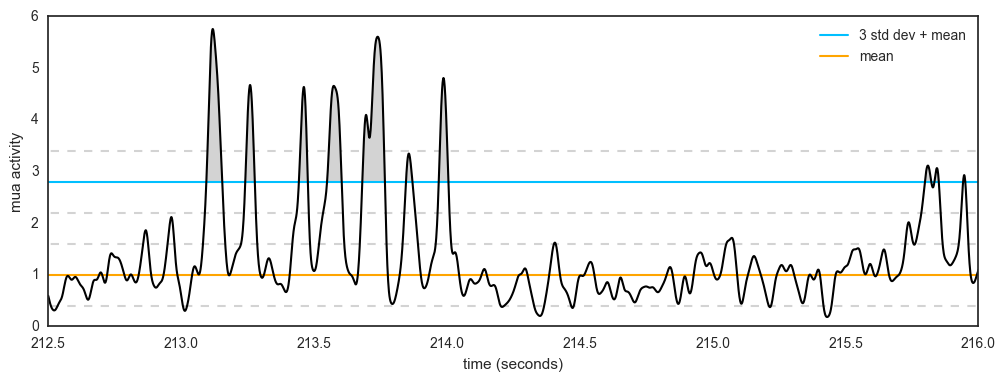

In [11]:
plt.plot(bin_cntrs,smoothed_spikes, color = 'black')
plt.hlines(smoothed_spikes.mean() + 3*smoothed_spikes.std(),xmin=0, xmax=2600, color='deepskyblue', label='3 std dev + mean')
plt.hlines(smoothed_spikes.mean() - 1*smoothed_spikes.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
plt.hlines(smoothed_spikes.mean() + 1*smoothed_spikes.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
plt.hlines(smoothed_spikes.mean() + 2*smoothed_spikes.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
plt.hlines(smoothed_spikes.mean() + 4*smoothed_spikes.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
plt.hlines(smoothed_spikes.mean(),xmin=0, xmax=2600, color='orange', label='mean')
plt.fill_between(bin_cntrs,3*smoothed_spikes.std() + smoothed_spikes.mean(),np.maximum(smoothed_spikes, smoothed_spikes.mean() + 3*smoothed_spikes.std()), color='lightgray')
plt.xlim([212.5,216])
plt.legend()
plt.xlabel('time (seconds)')
plt.ylabel('mua activity')


### 2. Exact spike time smoothing

Here we center a Gaussian on each spike and integrate the contribution of each spike within each bin to arrive at an exact (up to spike time precision) representation of the smoothed spike train. Note that this approach is conceptually clear and satisfying, but computationally expensive. Indeed, by first binning all the spikes into 1 ms bins, and then doing smoothing (with inexactly positions Gaussians) we obtain the same smoothed spike density in less than a second, compared to several hours for the exact analysis...

In [12]:
do_exact = False

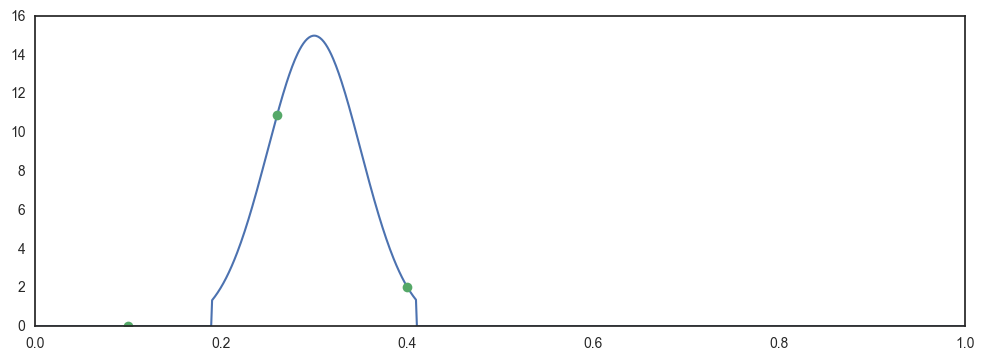

In [13]:
def gauss_maker(mu,sigma,A=None, bw=None):
    # bw is the bandwidth outside of which the function is considered 0:
    k = 1 / (sigma*np.sqrt(2*np.pi))
    s = -1.0 / (2 * sigma * sigma)
 
    if bw is not None:
        b = 0.5*bw
    def f(x): # with A, no bw
        return A*np.exp(s*(x-mu)*(x-mu)) # Gaussian with height A
    def g(x): # with A and bw
        return A*np.exp(s*(x-mu)*(x-mu))*(np.logical_and((x-mu)<b, (mu-x)<b)) # Gaussian with height A
        
    def p(x): # with bw, no A
        return k*np.exp(s*(x-mu)*(x-mu))*(np.logical_and((x-mu)<b, (mu-x)<b)) # Gaussian pdf
    def q(x): # no bw, no A
        return k*np.exp(s*(x-mu)*(x-mu)) # Gaussian pdf
            
    if A is not None and bw is not None:
        return g
    elif A is not None:
        return f
    elif bw is not None:
        return p
    else:
        return q

x = np.linspace(0,1,1e3)
bw = 0.22 # bandwidth in seconds
g = gauss_maker(mu=0.3,sigma=0.05,A=15, bw=bw)
plt.plot(x,g(x))
x = np.array([0.1, 0.26, 0.4])
plt.plot(x,g(x),'o')

In [14]:
def auc_gauss(mu, sigma, A=None, llim=None, rlim=None ):
    # area under curve (auc) for a Gaussian with mean mu, std dev sigma, and peak amplitude A
    # if A is omitted, then the Gaussian is normalized to be a pdf ( that is, A = 1/(sigma * sqrt(2*pi)) )
    
    from scipy.special import erf
    
    if A is not None:
        n = sigma*A*np.sqrt(2*np.pi)
    else:
        n = 1
        
    s = 1 / np.sqrt(2)
    k = n / 2
    
    if llim is not None:
        llim = np.asarray(llim)
        zleft = (llim - mu) / sigma
        aucl = k * ( 1 + erf( zleft * s ) )
    else:
        aucl = 0
            
    if rlim is not None:
        rlim = np.asarray(rlim)
        zright = (rlim - mu) / sigma
        aucr = k * ( 1 + erf( zright * s ) )
    else:
        aucr = n
    
    return aucr - aucl

In [15]:
if do_exact:
    bins = [0., 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    st = 1.5
    sigma = 0.5
    bw = 2 #6*sigma
    le, re, bin_idx = get_spike_edges(st, bw, bins)

    g = gauss_maker(mu=st,sigma=sigma, bw=bw)
    plt.plot(bins,g(np.asarray(bins)))
    plt.plot(np.asarray(le),g(np.asarray(le)),'o', color='orange')
    plt.plot(np.asarray(re),g(np.asarray(re)),'.', color='k')
    print('total area: {}'.format(auc_gauss(mu=st,sigma=sigma, llim=le,rlim=re).sum()))
    smoothed_spike = auc_gauss(mu=st,sigma=sigma, llim=le,rlim=re)

    print(le, re, bin_idx, sep='\n')

In [16]:
def get_spike_edges(st, bw, bins):
    # returns a list of intervals and bin indices for spike Gaussian
    num_bins = len(bins) - 1
    
    # determine ALL bins that overlap with spike Gaussian:
    bin_idx = np.digitize([st-bw/2, st+bw/2], bins) - 1
    bin_idx[bin_idx < 0] = 0
    bin_idx[bin_idx > num_bins - 1] = num_bins - 1
    
    left_edges = []
    right_edges = []
    
    # leftmost bin
    left_edges.append(max(bins[bin_idx[0]],st-bw/2))
    right_edges.append(min(bins[bin_idx[0]+1], st+bw/2))
    #right_edges.append(bins[bin_idx[0]+1])
    
    # interior
    for bb in range(bin_idx[0]+1,bin_idx[-1]):
        left_edges.append(bins[bb])
        right_edges.append(bins[bb+1])
        
    # rightmost bin
    if st+bw/2 > right_edges[0]:
        left_edges.append(max(bins[bin_idx[1]],st-bw/2))
        right_edges.append(min(bins[bin_idx[1]+1], st+bw/2))
    
    #print(left_edges)
    #print(right_edges)
    bin_idx = np.arange(bin_idx[0],bin_idx[-1]+1)
    
    return left_edges, right_edges, bin_idx
    

In [17]:
if do_exact:
    ds = 0.001 # 1 ms
    sigma = 0.010 * spikes.samprate # 10 ms
    bw = 6 * sigma

    spks_bin, bins = bin_single_ordered_spike_list(allspiketimes, spikes.samprate, ds=ds, verbose=True)
    smoothed_spk_array = np.zeros(len(spks_bin))

    for st in allspiketimes:
        le, re, bin_idx = get_spike_edges(st, bw, bins*spikes.samprate)
        smoothed_spike = auc_gauss(mu=st,sigma=sigma, llim=le,rlim=re)
        smoothed_spk_array[bin_idx] += smoothed_spike


In [18]:
if do_exact:
    plt.plot(bins[:-1],smoothed_spk_array, label='exact', lw=1)
    plt.plot(xx,smoothed_spikes, color = 'black', linestyle='dashed', label='approx')
    plt.hlines(smoothed_spk_array.mean() + 3*smoothed_spk_array.std(),xmin=0, xmax=2600, color='deepskyblue', label='3 std dev + mean')
    plt.hlines(smoothed_spk_array.mean() - 1*smoothed_spk_array.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
    plt.hlines(smoothed_spk_array.mean() + 1*smoothed_spk_array.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
    plt.hlines(smoothed_spk_array.mean() + 2*smoothed_spk_array.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
    plt.hlines(smoothed_spk_array.mean() + 4*smoothed_spk_array.std(),xmin=0, xmax=2600, color='lightgray', linestyles='dashed')
    plt.hlines(smoothed_spk_array.mean(),xmin=0, xmax=2600, color='orange', label='mean')
    plt.fill_between(bins[:-1],3*smoothed_spk_array.std() + smoothed_spk_array.mean(),np.maximum(smoothed_spk_array, smoothed_spk_array.mean() + 3*smoothed_spk_array.std()))
    #plt.xlim([118,120])
    plt.xlim([55,58])
    plt.legend()
    plt.xlabel('time (seconds)')
    plt.ylabel('mua activity')

    RMSE = np.sqrt(((smoothed_spk_array - smoothed_spikes)*(smoothed_spk_array - smoothed_spikes)).mean())
    print('The RMSE between exact and approx ({} ms) smoothing is {}'.format(ds*1000,RMSE))

# The RMSE between exact and approx (1.0 ms) smoothing is 0.0022792443503810824

## MUA event detection

In [19]:
from itertools import groupby
from operator import itemgetter
def find_threshold_crossing_events(x, threshold) :
    above_threshold = np.where(x > threshold, 1, 0);
    eventlist = []
    eventmax = []
    for k,v in groupby(enumerate(above_threshold),key=itemgetter(1)):
        if k:
            v = list(v)
            eventlist.append([v[0][0],v[-1][0]])
            try :
                eventmax.append(x[v[0][0]:(v[-1][0]+1)].max())
            except :
                print(v, x[v[0][0]:v[-1][0]])
                
    eventmax = np.asarray(eventmax)
    eventlist = np.asarray(eventlist)
    return eventlist, eventmax

In [20]:
threshold = np.mean(smoothed_spikes) + 3*np.std(smoothed_spikes)
mua_events, _ = find_threshold_crossing_events(smoothed_spikes, threshold)

In [21]:
# Find periods where value is > SecondaryThreshold; note that the previous periods should be within these!
SecondaryThreshold = np.mean(smoothed_spikes) + 0 * np.std(smoothed_spikes)
assert SecondaryThreshold < threshold, "Secondary Threshold by definition should include more data than Primary Threshold"

mua_bounds, broader_maxes = find_threshold_crossing_events(smoothed_spikes, SecondaryThreshold)

# Find corresponding big windows for potential mua events
#  Specifically, look for closest left edge that is just smaller
outer_boundary_indices = np.searchsorted(mua_bounds[:,0], mua_events[:,0]);
#  searchsorted finds the index after, so subtract one to get index before
outer_boundary_indices = outer_boundary_indices - 1;

# Find extended boundaries for mua events by pairing to larger windows
#   (Note that there may be repeats if the larger window contains multiple > 3SD sections)
mua_bounds = mua_bounds[outer_boundary_indices,:]
mua_maxes = broader_maxes[outer_boundary_indices]

# Now, since all that we care about are the larger windows, so we should get rid of repeats
_, unique_idx = np.unique(mua_bounds[:,0], return_index=True)
mua_bounds = mua_bounds[unique_idx,:]
mua_maxes = mua_maxes[unique_idx]
mua_events = mua_events[unique_idx,:]

In [22]:
### FFFB! We want to apply min 70 ms req, but only after we have the boundaries of the events... not just the crossings
# Keep only events that are long enough (LengthCriteria s)
LengthCriteria = 0.070 # 70 ms
FS = 1 / ds
mua_events = mua_events[mua_bounds[:,1] - mua_bounds[:,0] >= np.round(FS*LengthCriteria),:]
mua_bounds = mua_bounds[mua_bounds[:,1] - mua_bounds[:,0] >= np.round(FS*LengthCriteria),:]

print('{} MUA events detected'.format(len(mua_events)))

print('WARNING!! Maximum event duration not yet handled... (but min event duration is now {0} ms)'.format(1000*LengthCriteria))

817 MUA events detected
WARNING!! Maximum event duration not yet handled... (but min event duration is now 70.0 ms)


In [23]:
MUALenghts = mua_bounds[:,1] - mua_bounds[:,0]

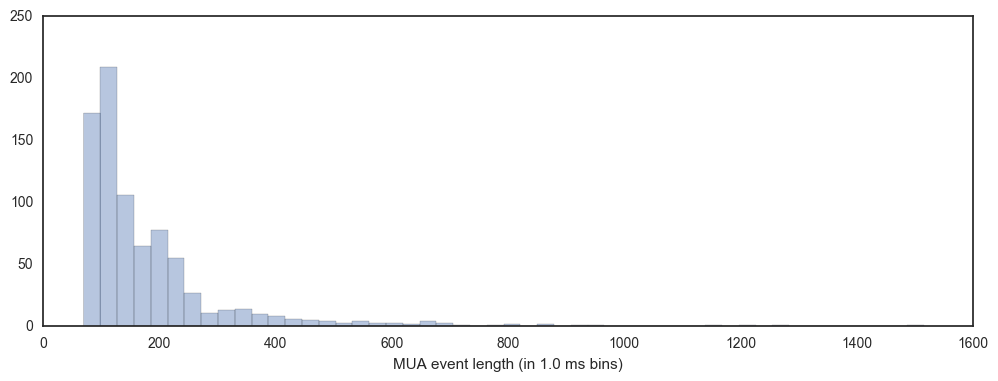

In [24]:
sns.distplot(MUALenghts,kde=False , axlabel='MUA event length (in {0} ms bins)'.format(1000*ds))

(2584938, 2588108)

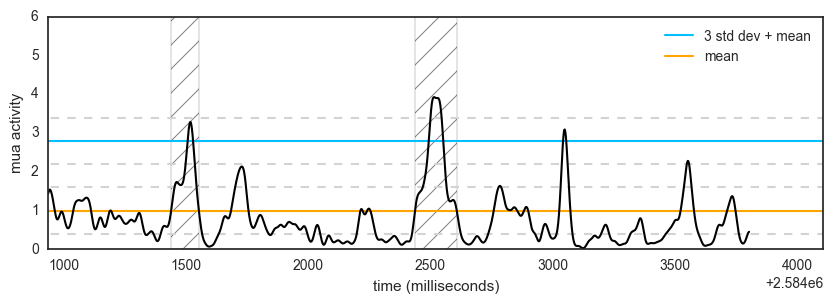

In [25]:
event_id = 1

import matplotlib.patches as patches

fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))

ax1.plot(smoothed_spikes, color = 'black')
ax1.hlines(smoothed_spikes.mean() + 3*smoothed_spikes.std(),xmin=0, xmax=2600000, color='deepskyblue', label='3 std dev + mean')
ax1.hlines(smoothed_spikes.mean() - 1*smoothed_spikes.std(),xmin=0, xmax=2600000, color='lightgray', linestyles='dashed')
ax1.hlines(smoothed_spikes.mean() + 1*smoothed_spikes.std(),xmin=0, xmax=2600000, color='lightgray', linestyles='dashed')
ax1.hlines(smoothed_spikes.mean() + 2*smoothed_spikes.std(),xmin=0, xmax=2600000, color='lightgray', linestyles='dashed')
ax1.hlines(smoothed_spikes.mean() + 4*smoothed_spikes.std(),xmin=0, xmax=2600000, color='lightgray', linestyles='dashed')
ax1.hlines(smoothed_spikes.mean(),xmin=0, xmax=2600000, color='orange', label='mean')
#ax1.vlines(mua_bounds[event_id,0],ymin=0, ymax=2)
#ax1.vlines(mua_bounds[event_id,1],ymin=0, ymax=2)
#ax1.fill_between(bin_cntrs,3*smoothed_spikes.std() + smoothed_spikes.mean(),np.maximum(smoothed_spikes, smoothed_spikes.mean() + 3*smoothed_spikes.std()), color='lightgray')
ax1.legend()
ax1.set_xlabel('time (milliseconds)')
ax1.set_ylabel('mua activity')

for event_id in range(0,len(mua_events)):
    #ax1.vlines(mua_bounds[event_id,0],ymin=0, ymax=2)
    #ax1.vlines(mua_bounds[event_id,1],ymin=0, ymax=2)

    ax1.add_patch(
        patches.Rectangle(
            (mua_bounds[event_id,0], 0),   # (x,y)
            mua_bounds[event_id,1] - mua_bounds[event_id,0] ,          # width
            10,          # height
            hatch='/',
            facecolor='w',
            alpha=0.5
        )
    )
    
ax1.set_xlim([mua_bounds[event_id,0]-1500,mua_bounds[event_id,1]+1500])



## Extract sequences corresponding to MUA events

We also want to be able to restrict MUA events based on movement speed; maybe we WANT non-stationary sequences for some reason? Therefore, the solution should be fairly flexible.

In [26]:
def get_speed_during_MUA_event(bounds, mua_FS, speed):
    # returns the average running speed for each MUA event
    sbl = np.round(bounds[:,0] / mua_FS * speed.samprate).astype(np.int) # speed [index] bounds left
    sbr = np.round(bounds[:,1] / mua_FS * speed.samprate).astype(np.int) # speed [index] bounds right

    mua_speeds = (speed.data[sbl[ii]:sbr[ii]].mean() for ii in np.arange(bounds.shape[0]))

    return mua_speeds
    

In [27]:
mua_speeds = get_speed_during_MUA_event(mua_bounds, FS, speed)
mua_speeds = np.array(list(mua_speeds))

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


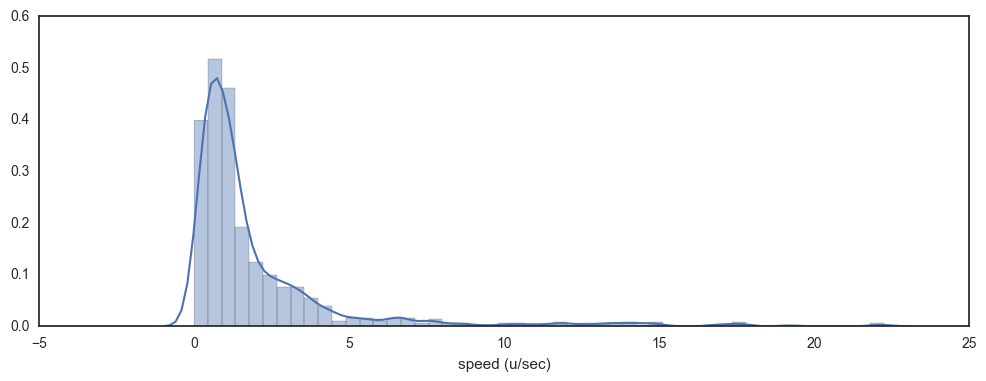

In [28]:
sns.distplot(mua_speeds, axlabel='speed (u/sec)')

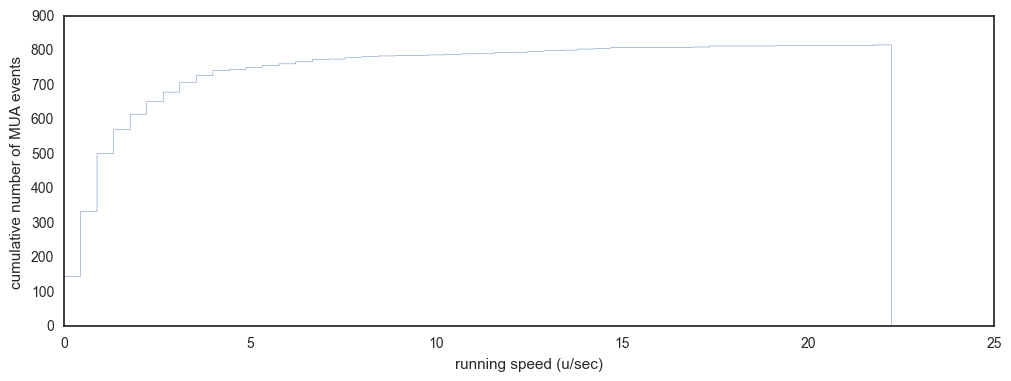

In [29]:
#plt.plot(mua_speeds[mua_speeds < 1])

n_bins = 50

_,_,_ = plt.hist(mua_speeds, bins=n_bins, normed=0, histtype='step', cumulative=True)
plt.xlabel('running speed (u/sec)')
plt.ylabel('cumulative number of MUA events')

### Question:

Currently I use the smoothed, instantaneous velocity estimates to determine the average velocity WITHIN MUA events. However, the velocity is computed with position estimates only every 30 ms or so, and the MUA events have a much finer timescale. Additionally, should I really care about instantaneous velocity, or do I want to identify MUA events which fall WELL INSIDE a period of inactivity?

In [30]:
def bin_and_stack_spikes_from_mua_events(st_array, ds, fs, mua_bounds, mua_bounds_fs, verbose=False):
    # bin and stack spikes from st_array (spikes.data) within the boundaries set by mua_bounds
    # mua_bounds is a Nx2 array of [start, stop] boundaries in mua_bounds_fs sample numbers
    
    # TODO: this is pretty slow when we provide boundaries. However, we can trivially parallelize the computation across units
    
    if verbose:
        print('binning {0} mua-event spike sequences into time bins of width {1} ms...'.format(len(st_array), ds))
        
    binned_spikes = klab.bin_spikes(st_array, ds=ds, fs=fs, boundaries=mua_bounds, boundaries_fs=mua_bounds_fs ,verbose=verbose)
    stkd = sq.data_stack(binned_spikes)
    return stkd

In [31]:
mua_bounds_fs = 1/ds
upsec = 1; # maximum speed (in units per sec, upsec) for mua events

mua_bounds_subset = mua_bounds[mua_speeds <= upsec] # restrict MUA events to only those where the animal was running slower than 1 units/s
MUALenghts_subset = MUALenghts[mua_speeds <= upsec]

# TODO: this is pretty slow when we provide boundaries. However, we can trivially parallelize the computation across units
mua_seq_stk_1ms_1upsec = bin_and_stack_spikes_from_mua_events(st_array=spikes.data, ds=ds, fs=spikes.samprate, mua_bounds=mua_bounds_subset, mua_bounds_fs=mua_bounds_fs, verbose=True)

binning 91 mua-event spike sequences into time bins of width 0.001 ms...


### Next steps:

* DONE! stack binned spike counts for mua events to enable us to evaluate sequences in models, as well as to train models explicitly

* we want to train an HMM on ds = 125 ms behavioral (> 8 u/sec) data, and use it to decode ds = 1 ms inactive (< 1 u/sec) data

* we can also learn an HMM using the mua sequences directly (to what end? definitely want to, but not priority?)

* we can also use 125msHMM to score mua events (similar to decoding, in that we assume the two models are related despite time compression and active v inactive states)

* identify SWRs and quantify rate of coincidence with MUAs

* do traditional replay analysis

### Bin data and train model

We start by training a model on RUN > 8 data in 125 ms bins. We then compute the (posterior) distribution over states at each time step. If we take the most likely state at each time step, we get the symbol-by-symbol maximum a posteriori sequence of states. However, this symbol-by-symbol MAP sequence _might_ not be a valid sequence through the model! So a popular (and sometimes superior) sequence is obtained by the celebrated Viterbi or maximum likleihood sequence estimate (MLSE).

In [ ]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

centerx = (np.array(posdf['x1']) + np.array(posdf['x2']))/2
centery = (np.array(posdf['y1']) + np.array(posdf['y2']))/2

tend = len(speed.data)/speed.samprate # end in seconds
time_axis = np.arange(0,len(speed.data))/speed.samprate
speed_125, tvel_125 = klab.resample_velocity(velocity=speed.data,t_bin=ds,tvel=time_axis,t0=0,tend=tend)
truepos_125 = np.interp(np.arange(0,len(binned_spikes.data))*ds,time_axis,centerx)

# get bins where rat was running faster than thresh units per second
runidx_125 = np.where(speed_125>8)[0]
seq_stk_run_125 = extract_subsequences_from_binned_spikes(binned_spikes,runidx_125)

## split data into train, test, and validation sets:
tr_b2,vl_b2,ts_b2 = sq.data_split(seq_stk_run_125, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
num_states = 35
myhmm2 = sq.hmm_train(tr_b2, num_states=num_states, n_iter=50, verbose=False)

In [ ]:
def get_replay_score_from_hmmlearn( hmmlearnModel, pth, obs ):
    # pth is a list of state indices, obs is a list (seq len) of lists (num cells) of nparray(rate)
    #P = np.exp(ymModel.dense_transition_matrix())
    logP = np.log(hmmlearnModel.transmat_)
    logPseq = 0
    logPctx = 0
    for ii in np.arange( 0, len(pth)-1 ):
        # add transition probability to sequence score:
        logPseq += logP[pth[ii],pth[ii+1]]
        # add memoryless observation likelihood to contextual score:
        logPctx += hmmlearnModel.score(obs[ii,:].reshape(1,-1)) # memoryless map probability per symbol FFFB! What about prior state probs?
        #logPctx += np.log(hmmlearnModel.predict_proba(obs[ii,:])[0][hmmlearnModel.decode(obs[ii,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
        #print(logPctx)
    logPctx += hmmlearnModel.score(obs[-1,:].reshape(1,-1)) # memoryless map probability per symbol
    #logPctx += np.log(hmmlearnModel.predict_proba(obs[-1,:])[0][hmmlearnModel.decode(obs[-1,:])[1][0]]) # memoryless map probability per symbol FFFB! What about prior state probs?model.predict_proba(obs[ii-1,:])[0][model.decode(obs[ii-1,:])[1][0]]
    
    return logPseq/len(pth), logPctx/len(pth)

In [ ]:
# compute replay scores on all candidate events, and compare to trajectory shuffle:
from random import shuffle

#data_to_test = seq_stk_bvr
data_to_test = mua_seq_stk_1ms_1upsec *50 # note: do Gaussian kernel scaling... with illustration
#data_to_test = ts_b2

myStackedDataSeq = data_to_test.data.copy()
myStackedSeqLengths = data_to_test.sequence_lengths.copy()

scores_seq2 = np.zeros(len(myStackedSeqLengths))
scores_ctx2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_seq2 = np.zeros(len(myStackedSeqLengths))
scores_shfl_ctx2 = np.zeros(len(myStackedSeqLengths))

ulen2 = []

seqlimits = np.cumsum(np.array([0] + list(myStackedSeqLengths)))
for ee in np.arange(0,len(myStackedSeqLengths)):
    obs = myStackedDataSeq[seqlimits[ee]:seqlimits[ee+1],:]
    lp, pth = myhmm2.decode(obs,algorithm='viterbi')
    trj_shfl_idx = np.arange(0,len(pth))
    shuffle(trj_shfl_idx)
    pth_trj_shfl = [pth[i] for i in trj_shfl_idx]
    obs_trj_shfl = np.array([obs[i] for i in trj_shfl_idx])
    
    scores_seq2[ee], scores_ctx2[ee] = get_replay_score_from_hmmlearn(myhmm2, pth, obs)
    scores_shfl_seq2[ee], scores_shfl_ctx2[ee] = get_replay_score_from_hmmlearn(myhmm2, pth_trj_shfl, obs_trj_shfl)
    #print(ee)
    
    ulen2.append(len(set(pth))) # number of unique states visited in path
    
slen2 = myStackedSeqLengths # sequence lengths


In [ ]:
print(np.array(scores_seq2).mean())
print(np.array(scores_shfl_seq2).mean())
print("Average number of unique states visited per sequence: {0}".format(np.array(ulen2).mean()))

In [ ]:
f, ax = plt.subplots(1,1, figsize=(5, 3))

#ax.scatter(np.exp(scores_seq2)*np.array(ulen2), scores_ctx2, s=80, c='mediumseagreen', alpha=0.3, marker='o',facecolors='none', edgecolors='gray',linewidth=1, label='candidate sequences')
#ax.scatter(np.exp(scores_shfl_seq2)*np.array(ulen2), scores_shfl_ctx2, c='k', s=80, marker='.',facecolors='none', edgecolors='none',linewidth=1, label='trajectory shuffled')
ax.scatter(np.exp(scores_seq2)*np.array(ulen2), scores_ctx2, s=80, c='skyblue', alpha=0.75, marker='o',facecolors='none', edgecolors='gray',linewidth=1, label='candidate sequences')
ax.scatter(np.exp(scores_shfl_seq2)*np.array(ulen2), scores_shfl_ctx2, c='gray', s=120, marker='x',facecolors='none', edgecolors='black',linewidth=1, label='trajectory shuffled')

ax.axvline(x=1, linewidth=1, color = 'gray', linestyle='dotted')
ax.set_xlabel('$\exp(q_{seq})$')
ax.set_ylabel('$q_{ctx}$')
ax.legend(loc='lower right', fancybox=True, framealpha=0.5, frameon=True)
#ax.set_title('novel sequence score on subsequences of hc-3 data')

# saveFigure("posterfigs/replay-score.pdf")

## MUA and ripple coincidence

Draw scatter plot showing MUA event time on x-axis, and closest-in-time SWR event time on y-axis. Also, show consider showing durations somehow? We still have the size and color of the points with which to show additional information.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%gui qt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('click on points')

line, = ax.plot(np.random.rand(100), 'o', picker=5)  # 5 points tolerance

def onpick(event):
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    points = tuple(zip(xdata[ind], ydata[ind]))
    print('onpick points:', points)

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()